# mean reversion 

In [1]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

symbolsIds = ['SPY', 'AAPL', 'ADBE', 'LUV', 'MSFT', 'SKYW', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM']

def load_financial_data(symbols, start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
    except FileNotFoundError:
        print("file not found")
        df = data.get_data_yahoo(symbols, start="2013-01-01", end="2023-03-31")
        df.to_pickle(output_file)
    return df

data = load_financial_data(symbolsIds, start_date='2001-01-01', end_date='2023-03-15', output_file='multi_data_large.pkl')

In [3]:
pvalues, pairs = find_cointegrated_pairs(data['Adj Close'])

<AxesSubplot:>

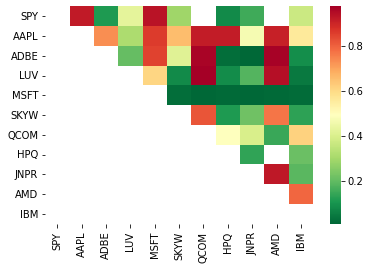

In [4]:
seaborn.heatmap(pvalues, xticklabels=symbolsIds, yticklabels=symbolsIds, cmap='RdYlGn_r', mask=(pvalues >= 0.98))

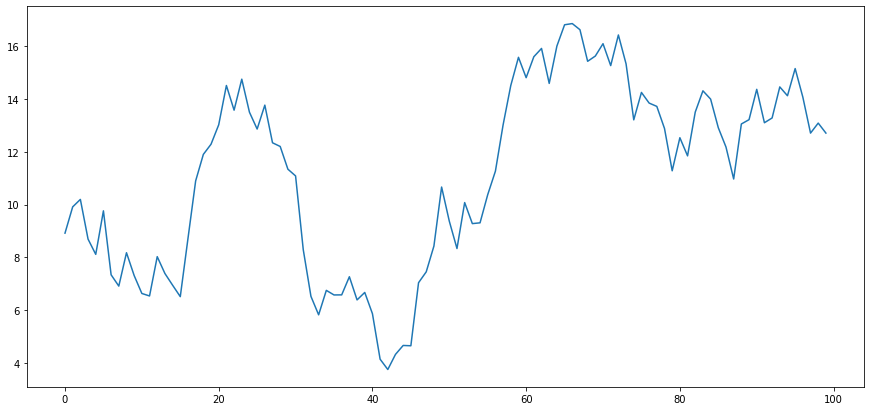

In [29]:
np.random.seed(123)

symbol1_returns = np.random.normal(0, 1, 100)

symbol1_prices = pd.Series(np.cumsum(symbol1_returns), name='symbol1')+10

symbol1_prices.plot(figsize=(15, 7))
plt.show()

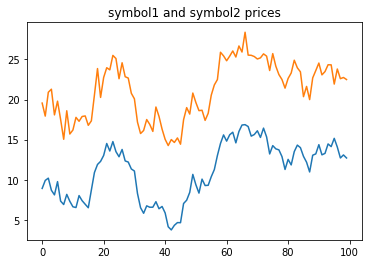

In [30]:
noise = np.random.normal(0, 1, 100)
symbol2_prices = symbol1_prices + 10 + noise
symbol2_prices.name = 'symbol2'
plt.title("symbol1 and symbol2 prices")
symbol1_prices.plot()
symbol2_prices.plot()
plt.show()

In [31]:
score, pvalue, _ = coint(symbol1_prices, symbol2_prices)

In [32]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

<AxesSubplot:>

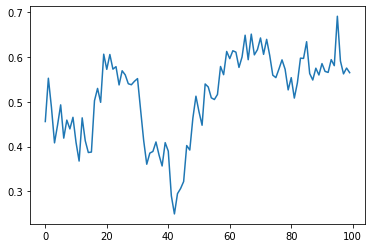

In [33]:
ratios = symbol1_prices /symbol2_prices
ratios.plot()

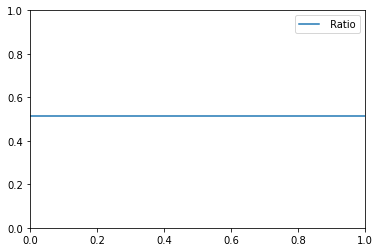

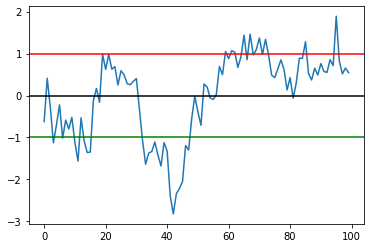

In [34]:
train = ratios[:75]
test = ratios[75:]

plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

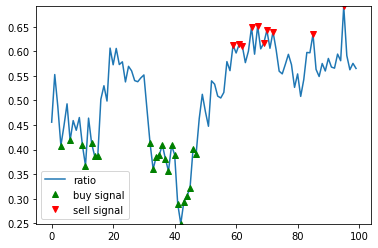

In [35]:
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color='g',  linestyle='None', marker='^')
sell.plot(color='r',  linestyle='None', marker='v')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['ratio', 'buy signal', 'sell signal'])
plt.show()

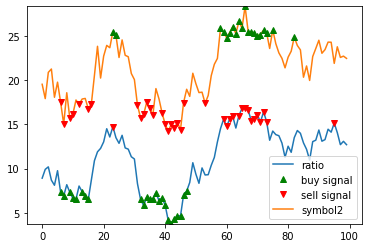

In [36]:
symbol1_prices.plot()
symbol1_buy = symbol1_prices.copy()
symbol1_sell = symbol1_prices.copy()
symbol1_buy[zscore(symbol1_prices)>-1] = 0
symbol1_sell[zscore(symbol1_prices)<1] = 0
symbol1_buy.plot(color='g',  linestyle='None', marker='^')
symbol1_sell.plot(color='r',  linestyle='None', marker='v')

symbol2_prices.plot()
symbol2_buy = symbol2_prices.copy()
symbol2_sell = symbol2_prices.copy()
symbol2_buy[zscore(symbol2_prices)<1] = 0
symbol2_sell[zscore(symbol2_prices)>-1] = 0
symbol2_buy.plot(color='g',  linestyle='None', marker='^')
symbol2_sell.plot(color='r',  linestyle='None', marker='v')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, symbol1_prices.min(), symbol2_prices.max()))
plt.legend(['ratio', 'buy signal', 'sell signal', 'symbol2'])
plt.show()

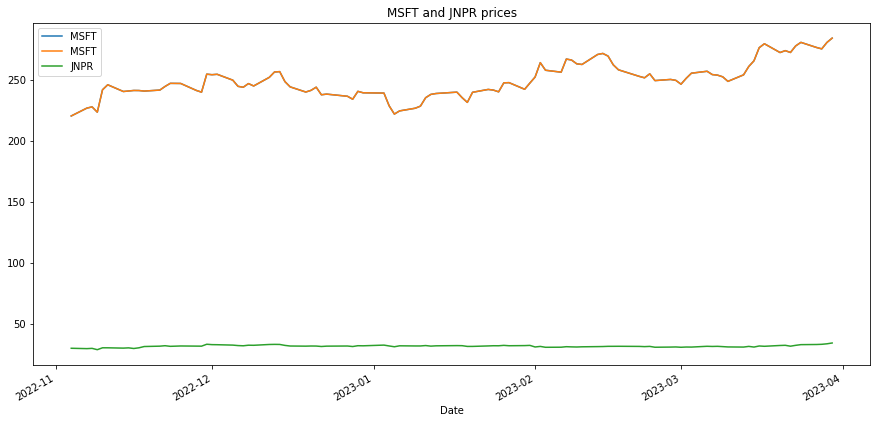

In [44]:
symbol1_prices = data['Adj Close']['MSFT'].tail(100)
symbol1_prices.plot(figsize=(15,7))
symbol2_prices = data['Adj Close']['JNPR'].tail(100)
symbol2_prices.name = 'JNPR'
plt.title('MSFT and JNPR prices')
symbol1_prices.plot()
symbol2_prices.plot()
plt.legend()
plt.show()

In [48]:
pair_correlation_trading_strategy = pd.DataFrame(index=symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price'] = symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(len(symbol1_prices))

In [46]:
position = 0
for i in range(len(symbol1_prices)):
    s1price = symbol1_prices[i]
    s2price = symbol2_prices[i]
    if not position and symbol1_buy[i] != 0:
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = -1
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(symbol1_prices) -1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 0
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = 0

<AxesSubplot:xlabel='Date'>

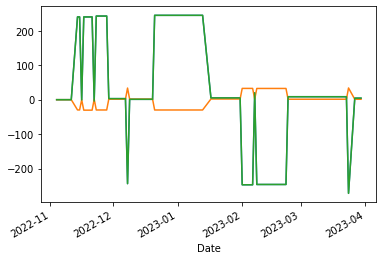

In [47]:
pair_correlation_trading_strategy['symbol1_position'] = pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']
pair_correlation_trading_strategy['symbol2_position'] = pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()

pair_correlation_trading_strategy['total_position'] = pair_correlation_trading_strategy['symbol1_position'] + pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()

In [51]:
pair_correlation_trading_strategy = pd.DataFrame(index=symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price'] = symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(len(symbol1_prices))
pair_correlation_trading_strategy['delta'] = np.zeros(len(symbol1_prices))
position = 0
s1_shares = 1000000
for i in range(len(symbol1_prices)):
    s1positions = symbol1_prices[i] * s1_shares
    s2positions = symbol2_prices[i] * int(s1positions/symbol2_prices[i])
    delta_position = s1positions - s2positions
    if not position and symbol1_buy[i] != 0:
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = -1
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = 0
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = 0

<AxesSubplot:xlabel='Date'>

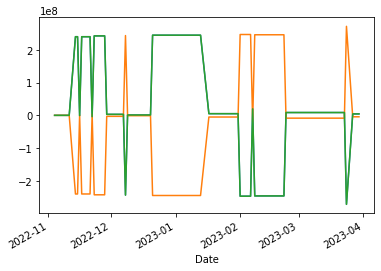

In [53]:
pair_correlation_trading_strategy['symbol1_position'] = pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']
pair_correlation_trading_strategy['symbol2_position'] = pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()

pair_correlation_trading_strategy['total_position'] = pair_correlation_trading_strategy['symbol1_position'] + pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()

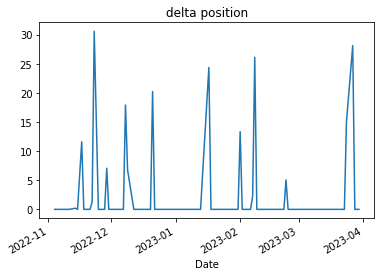

In [52]:
pair_correlation_trading_strategy['delta'].plot()
plt.title('delta position')
plt.show()